## References:
- https://arxiv.org/pdf/2004.11362.pdf
- https://towardsdatascience.com/contrastive-loss-for-supervised-classification-224ae35692e7

## Initial setup

In [2]:
!pip install tfds-nightly tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 29.0 MB/s eta 0:00:0000:0100:01


In [3]:
import tensorflow as tf
print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

2.12.0


In [4]:
!nvidia-smi

Sat Jun 24 11:18:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install wandb
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
!wget https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py

--2023-06-24 11:20:11--  https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5169 (5.0K) [text/plain]
Saving to: ‘losses.py’

losses.py           100%[===================>]   5.05K  --.-KB/s    in 0s      

2023-06-24 11:20:12 (37.8 MB/s) - ‘losses.py’ saved [5169/5169]



In [8]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
from wandb.keras import WandbCallback
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import losses
import time

#tf.random.set_seed(666)
#np.random.seed(666)

tfds.disable_progress_bar()

## Pets dataset

In [9]:
!git clone https://github.com/burkinabe/data.git

Cloning into 'data'...
remote: Enumerating objects: 1782, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 1782 (delta 6), reused 147 (delta 4), pack-reused 1632
Receiving objects: 100% (1782/1782), 876.64 MiB | 23.68 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Updating files: 100% (2598/2598), done.


In [10]:
train_data_dir = "data/test"
batch_size = 16
img_height = 248
img_width = 248

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  #validation_split=0.4,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1728 files belonging to 2 classes.


In [12]:
val_data_dir = "data/val"

In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_data_dir,
  #validation_split=0.81,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 864 files belonging to 2 classes.


In [14]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malicious']


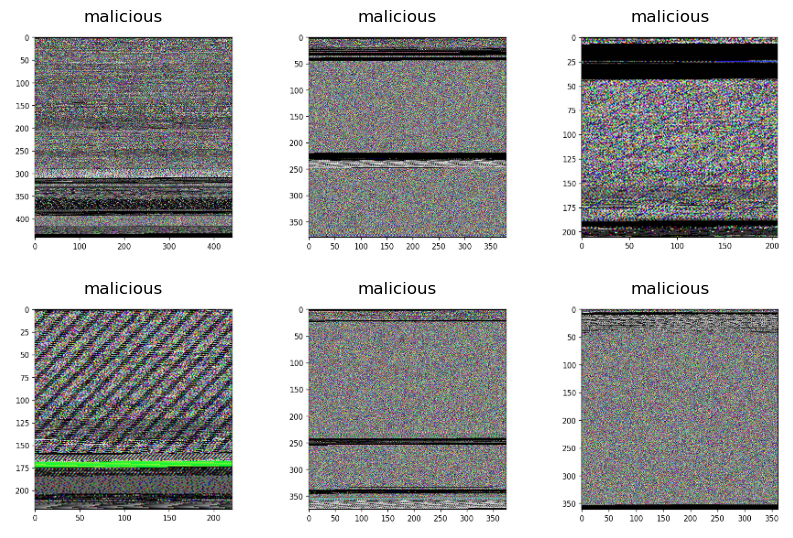

In [15]:
# Reference: https://keras.io/guides/transfer_learning/
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data pipeline

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 248, 248, 3)
(16,)


In [17]:
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (img_height, img_width))

    return (image, label)

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(batch_size)
    .prefetch(AUTO)
)


## Model building

In [18]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [19]:

# Encoder Network
def encoder_net():
    inputs = Input((img_height, img_width, 3))
    normalization_layer = UnitNormLayer()

    encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
    encoder.trainable = True

    embeddings = encoder(inputs, training=True)
    embeddings = GlobalAveragePooling2D()(embeddings)
    norm_embeddings = normalization_layer(embeddings)

    encoder_network = Model(inputs, norm_embeddings)

    return encoder_network

# Projector Network
def projector_net():
    projector = tf.keras.models.Sequential([
        Dense(128, activation="relu"),
        UnitNormLayer()
    ])

    return projector

## Running forward passes on a single image

In [20]:
encoder_r = encoder_net()
projector_z = projector_net()

images, _ = next(iter(train_ds))
r = encoder_r(images[0], 0)
z = projector_z(r)

print(tf.shape(r))
print(tf.shape(z))

tf.Tensor([  16 2048], shape=(2,), dtype=int32)
tf.Tensor([ 16 128], shape=(2,), dtype=int32)


## Training the encoder and the projector

In [21]:
optimizer = tf.keras.optimizers.Adam()

In [22]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels, metric='cosine')

	gradients = tape.gradient(loss,
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients,
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

In [23]:
from tensorflow.python.ops.numpy_ops import np_config
# Enable numpy-related methods in TensorFlow
np_config.enable_numpy_behavior()

In [24]:
tf.config.run_functions_eagerly(True)

  0%|          | 0/60 [00:00<?, ?it/s]

supervised_contrastive_loss : 0.3462829887866974
Epoch: 0 Loss: 0.346
supervised_contrastive_loss : 0.2350754737854004
supervised_contrastive_loss : 0.2084881067276001
supervised_contrastive_loss : 0.16152383387088776
supervised_contrastive_loss : 0.27265241742134094
supervised_contrastive_loss : 0.2915913164615631
supervised_contrastive_loss : 0.18185019493103027
supervised_contrastive_loss : 0.13836610317230225
supervised_contrastive_loss : 0.13026954233646393
supervised_contrastive_loss : 0.11551951617002487
supervised_contrastive_loss : 0.254221111536026
Epoch: 10 Loss: 0.254
supervised_contrastive_loss : 0.2262515276670456
supervised_contrastive_loss : 0.1677151918411255
supervised_contrastive_loss : 0.1643604338169098
supervised_contrastive_loss : 0.17282836139202118
supervised_contrastive_loss : 0.1054464727640152
supervised_contrastive_loss : 0.13745158910751343
supervised_contrastive_loss : 0.14844058454036713
supervised_contrastive_loss : 0.13674207031726837
supervised_contra

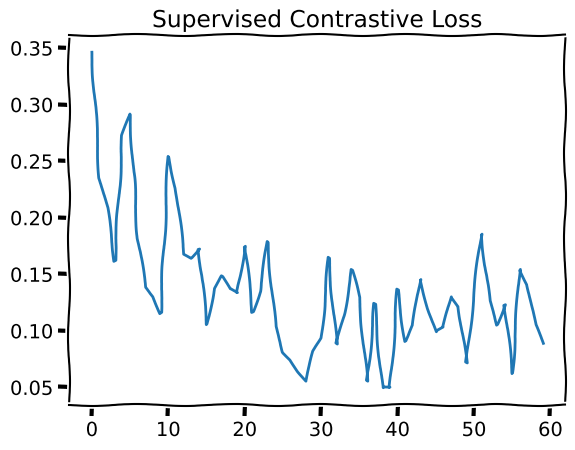

In [25]:
#wandb.init(project="scl", entity="authors", id="supervised-contrastive-crctd")
EPOCHS = 60
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for (images, labels) in train_ds:
        #print(labels.shape)
        loss = train_step(images[0], labels[0])
        epoch_loss_avg.update_state(loss)

    train_loss_results.append(epoch_loss_avg.result())
    print("supervised_contrastive_loss : {}".format(epoch_loss_avg.result()))

    if epoch % LOG_EVERY == 0:
        print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
print("training_time : {}".format((end - start)))

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()

## Supervised training

In [26]:
validation_ds = (
    val_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(batch_size)
    .prefetch(AUTO)
)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [27]:
def supervised_model():
    inputs = Input((img_height, img_width, 3))
    encoder_r.trainable = False
    print(inputs.shape)
    r = encoder_r(inputs, training=False)
    print(r.shape)
    outputs = Dense(1)(r)
    print(outputs.shape)
    supervised_model = Model(inputs, outputs)

    return supervised_model

In [28]:
from tensorflow import keras

In [30]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))

In [31]:
def _normalize_img(img, label):
    print(label[0].shape)
    img = tf.cast(img, tf.float32) / 255.
    print(img[0].shape)
    return (img[0], label[0])

In [32]:
validation_ds = validation_ds.map(_normalize_img)
train_ds = train_ds.map(_normalize_img)

(None,)
(None, 248, 248, 3)
(None,)
(None, 248, 248, 3)


In [33]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.BinaryCrossentropy(),
	metrics=[tf.keras.metrics.BinaryAccuracy()])

#wandb.init(project="scl", entity="burkinabe")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[CustomCallback(), es])

(None, 248, 248, 3)
(None, 2048)
(None, 1)
Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
Epoch 1/50
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'binary_accuracy']
1/7 [===>..........................] - ETA: 1:29 - loss: 2.3866 - binary_accuracy: 0.5000...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'binary_accuracy']
2/7 [=======>......................] - ETA: 1s - loss: 1.7970 - binary_accuracy: 0.5625  ...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'binary_accuracy']
3/7 [===========>..................] - ETA: 1s - loss: 1.6006 - binary_accuracy: 0.5625...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'binary_accuracy']
4/7 [================>.............] - ETA: 0s - loss: 1.5110 - binary_accuracy: 0.5469...Training: start of batch 4; got log

In [ ]:
# Lowering the learning rate
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	metrics=[tf.keras.metrics.BinaryAccuracy()])

wandb.init(project="scl", entity="burkinabe", id="low-lr")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[WandbCallback(), es])

(None, 248, 248, 3)


wandb: Currently logged in as: burkinabe. Use `wandb login --relogin` to force relogin


(None, 2048)
(None, 1)


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 0.6948 - binary_accuracy: 0.5000

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230624_120114-low-lr/files/model-best)... Done. 0.4s


7/7 [==============================] - 68s 9s/step - loss: 0.6948 - binary_accuracy: 0.5000 - val_loss: 0.6887 - val_binary_accuracy: 0.5938
Epoch 2/50
7/7 [==============================] - 26s 2s/step - loss: 0.6934 - binary_accuracy: 0.5357 - val_loss: 0.6913 - val_binary_accuracy: 0.5781
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.6873 - binary_accuracy: 0.6071

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230624_120114-low-lr/files/model-best)... Done. 0.4s


7/7 [==============================] - 68s 9s/step - loss: 0.6873 - binary_accuracy: 0.6071 - val_loss: 0.6813 - val_binary_accuracy: 0.6250
Epoch 4/50
2/7 [=======>......................] - ETA: 1s - loss: 0.6876 - binary_accuracy: 0.5625  

With more training for the encoder and the projector, we would have got better results. We did not use any augmentation policy for either of the trainings above, so including that would have also helped us enhance the performance.

## Serialize the model weights to GCS

In [ ]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration"
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [ ]:
!gsutil mb gs://supervised-contrastive

Creating gs://supervised-contrastive/...


In [ ]:
time_now = time.time()
encoder_r.save_weights("encoder_r_" + str(time_now) + ".h5")
projector_z.save_weights("projector_z" + str(time_now) + ".h5")

!gsutil -m cp -r *.h5 gs://supervised-contrastive/

Copying file://encoder_r_1590489813.9405909.h5 [Content-Type=application/octet-stream]...

Copying file://projector_z1590489813.9405909.h5 [Content-Type=application/octet-stream]...

\

Operation completed over 2 objects/91.2 MiB.                                     
